We don't have all the time in the world. Let's cut down on the data a bit.

One of the .csv files we're going to work with, "features.csv", is not organized in a standard way: it's multi-header, so reading it the regular way would give you some rows that are actually columns. Here's what we'll do:

# Extraction

In [2]:
library(dplyr)
library(ggplot2)

#1. Read first 4 rows as header info
header <- read.csv("features.csv", header = FALSE, nrows = 4)

#2. Read rest of file starting from 5th row
data <- read.csv("features.csv", skip = 4, header = FALSE) # This will take a while and hog lots of RAM

#3. Combine header information into one
combined_header <- apply(header, 2, function(col) paste(col, collapse = "_"))

#4. Handle duplicate names by assigning unique numbers
unique_combined_header <- make.unique(combined_header)

#5. Assign unique column names to data
colnames(data) <- unique_combined_header
colnames(data)[1] <- "track_id"

print(head(data))

  track_id chroma_cens_kurtosis_01_ chroma_cens_kurtosis_02_
1        2                7.1806526               5.23030901
2        3                1.8889633               0.76053929
3        5                0.5275630              -0.07765432
4       10                3.7022455              -0.29119304
5       20               -0.1938370              -0.19852678
6       26               -0.6995345              -0.68415791
  chroma_cens_kurtosis_03_ chroma_cens_kurtosis_04_ chroma_cens_kurtosis_05_
1               0.24932081                1.3476201                1.4824778
2               0.34529656                2.2952006                1.6540307
3              -0.27961031                0.6858831                1.9375696
4               2.19674206               -0.2344495                1.3673638
5               0.20154603                0.2585562                0.7752037
6               0.04882487                0.0426588               -0.8189669
  chroma_cens_kurtosis_06_ chroma_

# Transformation

 • Let's randomly sample 50% of the dataset for reduction. We can use sample_frac() for that:

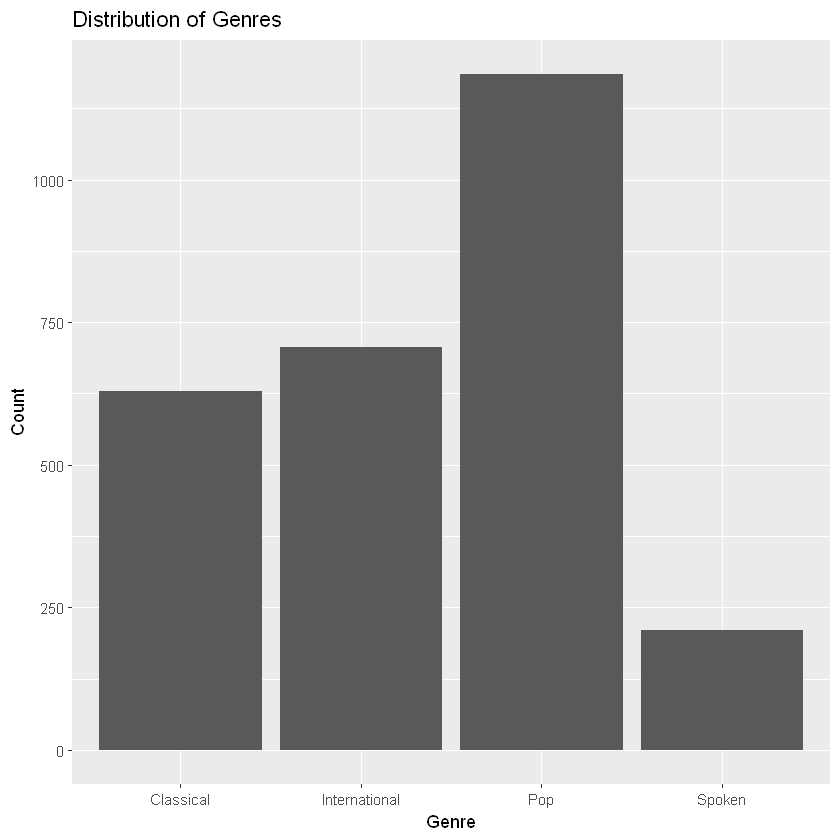

In [3]:
# Dr. Michael seems to have JOINed the genre_parent attribute to his music_all as well. Let's do the same:
track_genres <- read.csv("track_genres.csv")
music_all <- left_join(data, track_genres, by = "track_id")

# Sampling
music_sampled <- music_all %>% 
  sample_frac(0.5)

# Picking only a few genres
filtered_genres <- music_sampled %>%
  filter(genre_parent %in% c("Classical", "Pop", "International", "Spoken"))

ggplot(filtered_genres, aes(x = genre_parent)) +
  geom_bar() +
  ggtitle("Distribution of Genres") +
  xlab("Genre") +
  ylab("Count")

 •  Randomized sampling is a perfectly good way of selecting your data, but it has a risk: if the distributions of your genres are a bit off, or you have too little of one genre, you can't guarantee a similar distribution in the output.

 • In that case, we may use *stratified* sampling: it maintains the distribution of our classes.

# A tibble: 13,839 × 520
# Groups:   genre_parent [17]
   track_id chroma_cens_kurtosis…¹ chroma_cens_kurtosis…² chroma_cens_kurtosis…³
      <int>                  <dbl>                  <dbl>                  <dbl>
 1    69076                -0.947                   0.747               -0.679  
 2   151097                 0.483                  -0.193               -0.140  
 3    43026                 0.0956                  0.167               -0.310  
 4   146765                 0.288                   0.924                0.0644 
 5   140538                -0.320                  -0.664               -0.623  
 6    92760                 0.336                   1.82                -0.271  
 7   113255                -0.348                  -0.911               -1.33   
 8    71650                 0.637                  -1.00                 0.00483
 9   148606                -1.08                   -0.880                3.34   
10   142149                -0.0604                 -0.

Warning message:
"Use of `music_sampled$genre_parent` is discouraged.
ℹ Use `genre_parent` instead."


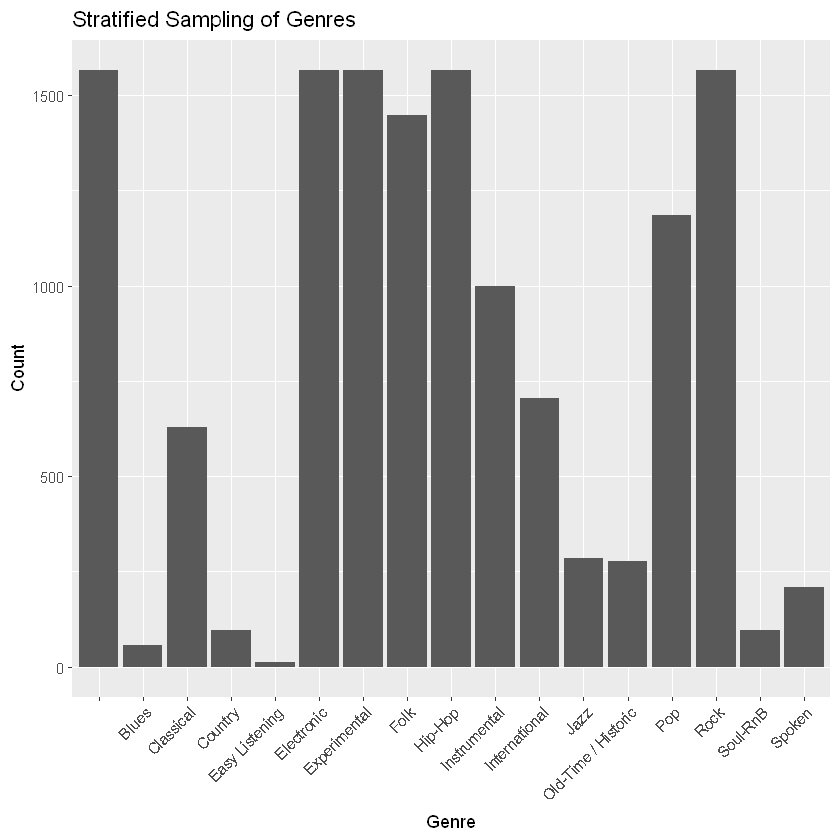

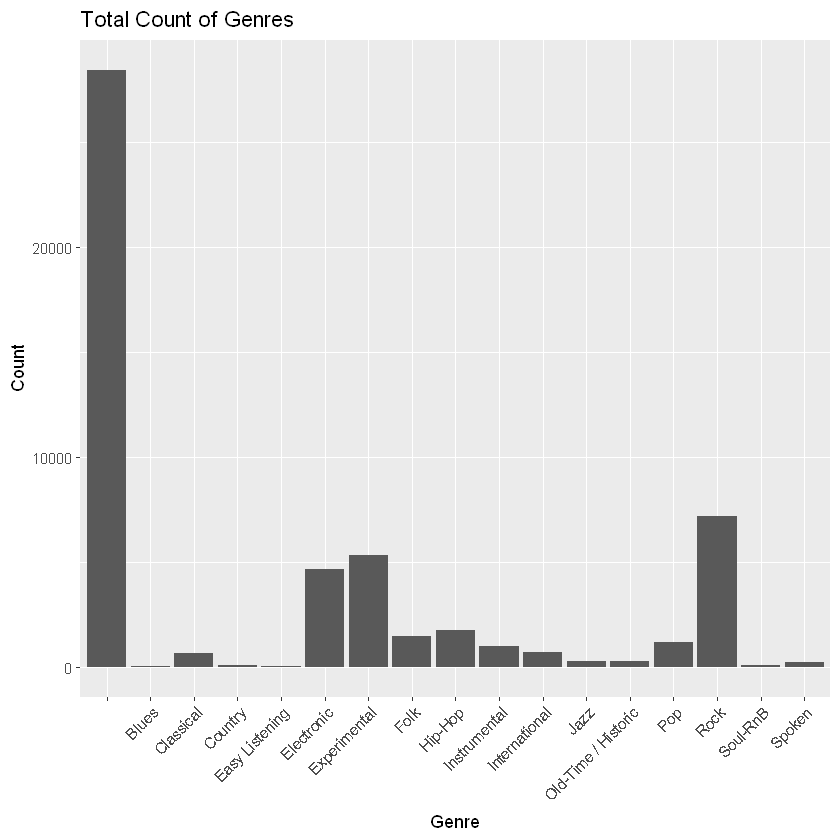

In [11]:
#install.packages("splitstackshape")
library(splitstackshape)

group_sizes <- table(music_sampled$genre_parent)
total_rows <- nrow(music_sampled)
desired_proportion <- 0.5
sample_sizes <- pmin(floor(total_rows * desired_proportion /
                             length(group_sizes)), group_sizes)

# Ensure sample_sizes is a named vector
sample_sizes <- as.numeric(sample_sizes)
names(sample_sizes) <- names(group_sizes)

# Create a data frame with genre_parent and sample sizes
sample_size_df <- data.frame(
  genre_parent = names(sample_sizes),
  sample_size = sample_sizes,
  stringsAsFactors = FALSE
)

# Join the sample size with the original data
sampled_stratified <- music_sampled %>%
  left_join(sample_size_df, by = "genre_parent") %>%
  group_by(genre_parent) %>%
  filter(row_number() <= sample_size) %>%
  select(-sample_size)  # Remove the sample_size column if no longer needed

# Print the results to check
print(sampled_stratified)

ggplot(sampled_stratified, aes(x = genre_parent)) +
  geom_bar() +
  ggtitle("Stratified Sampling of Genres") +
  xlab("Genre") +
  ylab("Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Total count of genres, for comparison
ggplot(music_sampled, aes(x = music_sampled$genre_parent)) +
  geom_bar() +
  ggtitle("Total Count of Genres") +
  xlab("Genre") +
  ylab("Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

 • Another way to reduce our data is by removing features with a high correlation via correlation analysis.

 [1] "chroma_cqt_kurtosis_01_" "chroma_cqt_kurtosis_02_"
 [3] "chroma_cqt_kurtosis_03_" "chroma_cqt_kurtosis_04_"
 [5] "chroma_cqt_kurtosis_05_" "chroma_cqt_kurtosis_06_"
 [7] "chroma_cqt_kurtosis_07_" "chroma_cqt_kurtosis_08_"
 [9] "chroma_cqt_kurtosis_09_" "chroma_cqt_kurtosis_10_"
[11] "chroma_cqt_kurtosis_11_" "chroma_cqt_kurtosis_12_"


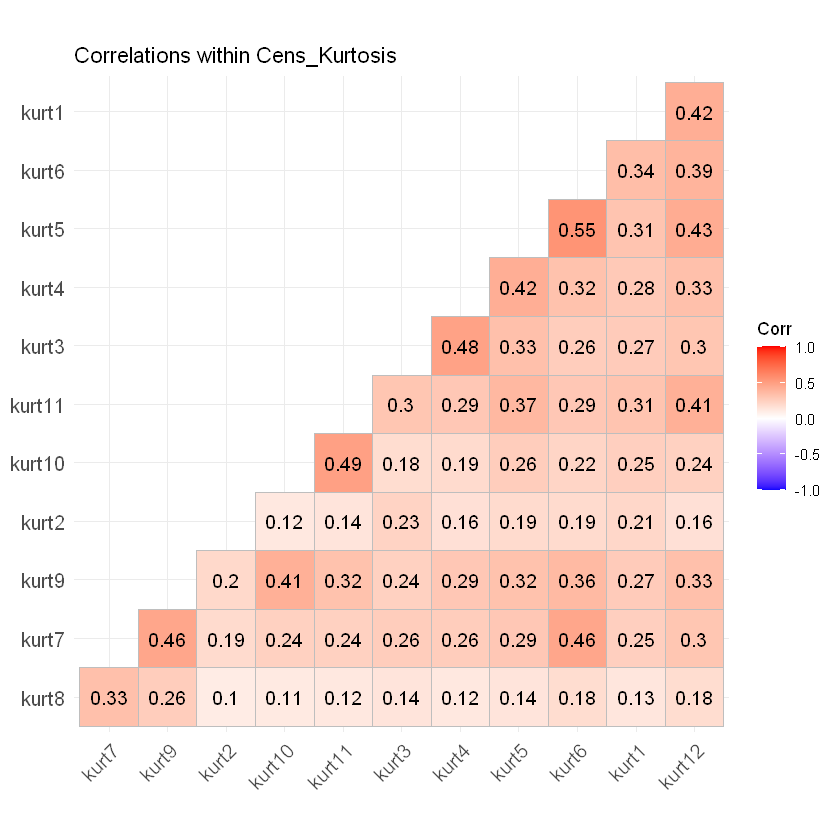

In [10]:
#install.packages("ggcorrplot")
library(ggcorrplot)

# Let's look at some echonest features and make a correlation matrix.

# Select columns starting with "chroma_cqt_kurtosis"
cqt_k <- sampled_stratified %>%
  ungroup() %>% # Ensures that only those columns will be included
  select(starts_with("chroma_cqt_kurtosis"))

# Check the names of the selected columns
print(names(cqt_k))

# Define new names and ensure there are enough new names for columns
new_names <- paste0("kurt", 1:ncol(cqt_k))

# Rename columns
names(cqt_k) <- new_names

cor_m = cor(cqt_k)

# Correlations of each kurt attribute to another. Based on this, you can decide on whether or not removing one is worth it.
ggcorrplot(cor_m, hc.order=TRUE, type="lower", lab=TRUE)+ggtitle("Correlations within Cens_Kurtosis")

Another route is via forward or backward attribute selection. With a machine learning algorithm in mind, we can measure its performance and keep removing or adding features in order to see if it changes.